In [132]:
import pandas as pd
import numpy as np

1. Loading data

In [133]:
df_train = pd.read_csv('archive/Paitients_Files_Train.csv')
df_test = pd.read_csv('archive/Paitients_Files_Test.csv')
display(df_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


None

2. Preprocessing the data

In [134]:
y = df_train['Sepssis'].map({'Positive':1, 'Negative': 0})
X = df_train.drop(['ID','Sepssis'], axis='columns')
y.value_counts()

0    391
1    208
Name: Sepssis, dtype: int64

In [135]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2023)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((479, 9), (120, 9), (479,), (120,))

In [137]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. Machine Learning Models

In [138]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [139]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000000000),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'GaussianNB': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(max_iter=10000000)
}

In [140]:
model_names = []
model_average_scores = []
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train)
    model_names.append(model_name)
    model_average_scores.append(scores.mean())

In [141]:
df_model = pd.DataFrame()
df_model['model'] = model_names
df_model['average score'] = model_average_scores
df_model

,model,average score
0,Logistic Regression,0.757785
1,Gradient Boosting,0.753640
2,Random Forest,0.747412
3,GaussianNB,0.749430
4,KNeighbors,0.695329
5,Neural Network,0.751601


In [142]:
from sklearn.metrics import classification_report
clf = GradientBoostingClassifier()
clf.fit(X_train_scaled, y_train)
y_predicted = clf.predict(X_test_scaled)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83        78
           1       0.68      0.62      0.65        42

    accuracy                           0.77       120
   macro avg       0.74      0.73      0.74       120
weighted avg       0.76      0.77      0.76       120



4. Partial Dependence Plots (PDP)

In [143]:
from sklearn.inspection import PartialDependenceDisplay
import seaborn as sns
import matplotlib.pyplot as plt

f_names = ["Plasma glucose (PRG)", "Blood Work Result-1 (PL)", "Blood Pressure (PR)", "Blood Work Result-2 (SK)", "Blood Work Result-2 (TS)", "Body mass index (M11)", "Blood Work Result-4 (BD2)","Age", "Has Insurance"]
clf2 = RandomForestClassifier()
X_scaled_df= pd.DataFrame(X_train_scaled, columns = f_names)
clf2.fit(X_scaled_df, y_train)
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title("Random Forests")
PartialDependenceDisplay.from_estimator(clf2, X_scaled_df, X_scaled_df.columns, ax=ax)


5. SHAP 

In [ ]:
import sklearn
import shap

shap.initjs()
X_train_summary = shap.kmeans(X_train_scaled, 50)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train_scaled, y_train)
explainer = shap.KernelExplainer(model=svm.predict_proba, data=X_train_summary, algorithm="kernel")
X_test_scaled_df= pd.DataFrame(X_test_scaled, columns = f_names)

In [145]:
shap_values = explainer.shap_values(X_test_scaled_df.iloc[0,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_scaled_df.iloc[0,:], feature_names=f_names)

In [146]:
shap_values = explainer.shap_values(X_test_scaled_df.iloc[1,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_scaled_df.iloc[1,:], feature_names=f_names)

In [147]:
shap_values = explainer.shap_values(X_test_scaled_df.iloc[13,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_scaled_df.iloc[13,:], feature_names=f_names)

100%|██████████| 120/120 [03:31<00:00,  1.76s/it]


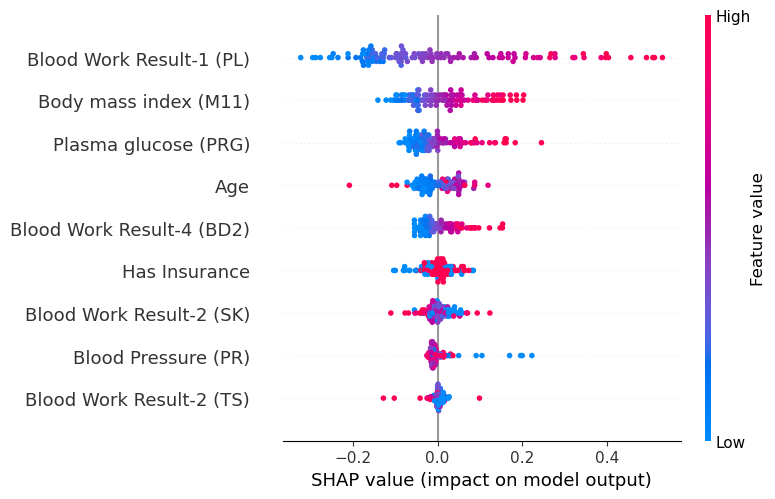

In [149]:
shap_values = explainer.shap_values(X_test_scaled_df)
shap.summary_plot(shap_values[1], X_test_scaled_df)